# **Load packages**

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# **MNIST train, test dataset 가져오기**

In [2]:
#"": 현재 폴더에 MNIST 있음
mnist_train=dset.MNIST("", train=True, transform = transforms.ToTensor(), #train 용으로 쓰겠다.
                       target_transform = None, download = False)
mnist_test=dset.MNIST("", train=False, transform = transforms.ToTensor(), #test 용으로 쓰겠다.
                       target_transform = None, download = False)

# **대략적인 데이터 형태**

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


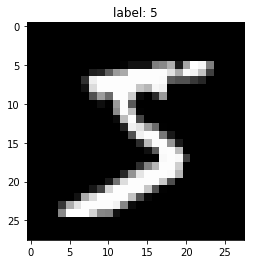

In [3]:
print "mnist_train 길이:", len(mnist_train)
print "mnist_test 길이:", len(mnist_test)

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print "image data 형태:", image.size()
print "label: ", label

# 그리기
img = image.numpy() # image 타입을 numpy 로 변환 (1, 28, 28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

# **MNIST data 띄워보기**

5
torch.Size([1, 28, 28])
5


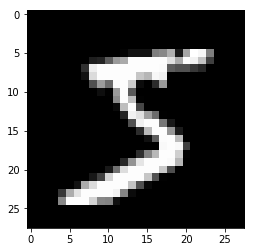

0


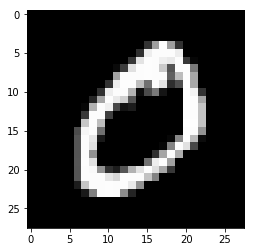

4


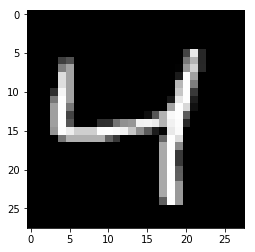

In [4]:
print(mnist_train[0][1]) # label
print(mnist_train[0][0].size()) # image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0],cmap='gray')
    plt.show()

# **convolution 하나 씌워보기**

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


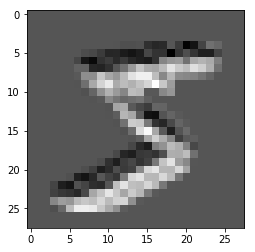

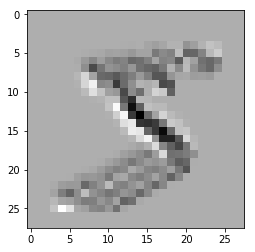

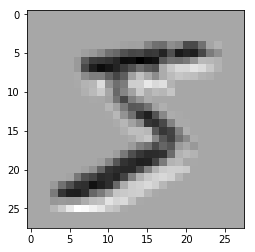

In [5]:
# mnist 의 첫 번째 이미지, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor 의 사이즈 조절, -1: 해당 차원의 차원을 확장시켜라
# [1, 28, 28] -> [1, 1, 28, 28]
image = image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print label

# convolutional filter 정의
conv_layer=nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
# image 에 filter 적용
output = conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0, i, :, :].data.numpy(), cmap='gray')
    plt.show()

# **CNN 만들기**

**train test data 가져오기**

In [6]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10 # 1000

In [53]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100], batch_size = batch_size # mnist_train 를 훈련시킴
                                           ,shuffle=True, num_workers = 2,
                                           drop_last = True) # batch_size 만큼 나눌 때 나버지는 버려라

test_loader = torch.utils.data.DataLoader((mnist_test),batch_size = batch_size,                    
                                          shuffle=False, num_workers = 2,
                                           drop_last = True) 

# **CNN 클래스 만들기 (모델 만들기)**

In [54]:
class CNN(nn.Module): #nn.Module 상속받음
    def __init__(self):
        super(CNN, self).__init__() # 28 x 28 / 1:input, 16: output, 5:kernel
        self.layer = nn.Sequential(
            nn.Conv2d(1, 16, 5, padding = 2),
            nn.ReLU(),
        
            nn.Conv2d(16, 32, 5, padding = 2), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 28 x 28 -> 14 x 14
        
            nn.Conv2d(32, 64, 5, padding = 2), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 14 x 14 -> 7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )
    
        
    def forward(self, x):
        out = self.layer(x)
        out = out.view(batch_size, -1) # 한줄로 펴주는거(64 * 7 * 7)
        out = self.fc_layer(out)
        return out
    
model = CNN() #.cuda()    

In [55]:
# 파라미터 체크하기
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [56]:
# loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# **Optimization**

In [57]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader): # batch_size 만큼
        x = Variable(image) # .cuda()
        y_ = Variable(label) # .cuda()
        
        optimizer.zero_grad() # optimizer 안에서 이전 gradient 들을 초기화.
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward() # gradient 계산
        optimizer.step() # parameter 업데이트
        
        if j%50==0:
            print(loss, j, i)

(tensor(2.3103, grad_fn=<NllLossBackward>), 0, 0)
(tensor(2.1694, grad_fn=<NllLossBackward>), 50, 0)
(tensor(0.8883, grad_fn=<NllLossBackward>), 0, 1)
(tensor(0.3860, grad_fn=<NllLossBackward>), 50, 1)
(tensor(0.5615, grad_fn=<NllLossBackward>), 0, 2)
(tensor(0.1256, grad_fn=<NllLossBackward>), 50, 2)
(tensor(0.1897, grad_fn=<NllLossBackward>), 0, 3)
(tensor(0.2626, grad_fn=<NllLossBackward>), 50, 3)
(tensor(0.2128, grad_fn=<NllLossBackward>), 0, 4)
(tensor(0.2329, grad_fn=<NllLossBackward>), 50, 4)
(tensor(0.0219, grad_fn=<NllLossBackward>), 0, 5)
(tensor(0.1065, grad_fn=<NllLossBackward>), 50, 5)
(tensor(0.5304, grad_fn=<NllLossBackward>), 0, 6)
(tensor(0.0132, grad_fn=<NllLossBackward>), 50, 6)
(tensor(0.0306, grad_fn=<NllLossBackward>), 0, 7)
(tensor(0.0663, grad_fn=<NllLossBackward>), 50, 7)
(tensor(0.0082, grad_fn=<NllLossBackward>), 0, 8)
(tensor(0.0089, grad_fn=<NllLossBackward>), 50, 8)
(tensor(0.0333, grad_fn=<NllLossBackward>), 0, 9)
(tensor(0.0024, grad_fn=<NllLossBackward>

In [58]:
# 모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

In [59]:
try:
    # 미리 학습시킨 네트워크의 파라미터 집합
    model = torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print('model not restored')

model restored


In [60]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼
        img = Variable(imgs) #.cuda()    # x
        label = Variable(labels) #.cuda()  # y
        
        output = imodel.forward(img) # forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print('Accuracy of Test Data: {}'.format(100*correct/total))
        

In [61]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 94.75
